# ¿Podemos estimar la edad de los abalones?

## Introducción al problema

Los haliótidos ([Haliotidae](https://es.wikipedia.org/wiki/Haliotis)) son una familia de moluscos gasterópodos con un único género, Haliotis, muy estimado por su carne. Son conocidos como orejas de mar y abulones, o con el término inglés de abalone, aunque se les conoce con otros nombres dependiendo del país: orea, señoritas, cribias, manquilinas, seis ojos, oreja de Venus, lapa burra y carne de pez. 
 
Las especies del género Haliotis habitan a lo largo de las zonas costeras de todos los continentes, siendo la costa este de Sudamérica y los Estados Unidos la que menor diversidad de especies presenta; conociéndose sólo dos especies vivientes en esta región Haliotis pourtalesii y Haliotis aurantium. La mayoría de las especies son originarias de las costas de las islas de Oceanía, África, Asia y el archipiélago japonés. 

El objetivo de este estudio será el de predecir la edad de los abalones desde las medidas físicas. Hasta ahora, la edad se determina cortando la concha a través del cono y contando el número de anillos a través de un microscopio y sumando ó restando a la cantidad resultante 1.5, lo que lleva mucho tiempo. Con este posible modelo, intentaremos predecir el número de anillos a partir de las características físicas de este molusco, sin necesidad de haberlo llevado al microscopio, lo cual facilitará enormemente el trabajo y agilizará el proceso de obtención de la edad.

## Conjunto de datos

Los datos, además de tenerlos en la carpeta "/datos/" están disponibles en https://archive.ics.uci.edu/ml/datasets/Abalone.

## Comentarios iniciales

Si nos vamos a la documentación nos dice que se ha sacado de "The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H. rubra) from the North Coast and Islands of Bass Strait". Traduciéndolo, nos dice que los individuos que se han muestreado en la [Costa Norte de Tasmania](https://es.wikipedia.org/wiki/Tasmania) y en el [estrecho de Bass](https://es.wikipedia.org/wiki/Estrecho_de_Bass).

Podemos notar aquí que puede que estemos ante un factor oculto puesto que a lo mejor se han producido mutaciones en la fisionomía de estos moluscos, lo cuál nos esté sesgando el modelo. Pero como no se nos ha proporcionado ninguna información sobre la procedencia, este estudio no va a tener en cuenta la posición geográfica de cada individuo (no existe, no nos la podemos inventar).

Por otro lado, en la documentación que se nos proporciona del dataset, se nos dice lo siguiente: "From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)". Traduciendo al castellano, viene a decir que los individuos cuyas muestras no estuviesen completas no han entrado en este dataset (la mayoría de estos tenían la variable respuesta como faltante) y además que los rangos de las variables continuas han sido escaladas para usarlas con una una red neuronal (Aritificial Neural Network). 

Entonces, podemos deducir que el modelo no será tan bueno, puesto que no disponemos de tanta información (a menos de que se hayan quitado pocos datos en comparación con los que tenemos ahora, y se hayan quitado de forma aleatoria, para no sesgar el modelo final) 

Debemos decir que existen dos observaciones cuya variable `height` vale 0. Como tenemos muchas observaciones podemos quitar esas dos observaciones, puesto que no se podrán aplicar transformaciones de la misma, como por ejemplo el logaritmo, o la inversa, dado que nos dará un resultado indeterminado. Comentar que si en el modelo final no se incluye ni height ni ninguna transformación, se pueden añadir.

## Importación de las librerías

Aquí irán todas las librerías que vayamos a usar en el Notebook. Las ponemos al principio porque sino hay peligro a que eliminemos alguna librería y provoque algún error inesperado.

In [101]:
import pandas as pd

## Lectura del conjunto de datos

In [78]:
datos_raw = pd.read_csv("./datos/abalone.txt", header=None)
datos_raw.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Who_weight', 'Shu_weight', 'Viscera', 'Shell', 'Rings']

## Análisis exploratorio

Estudiemos las anomalías que existen en nuestro conjunto de datos.

* Muestra un resumen del conjunto de datos para hacerte una idea de las variables presentes en el mismo.

* Elimina los dos registros que tienen la variable `Height` igual a 0.

* Muestra un diagrama de pares de variables con todas las variables cuya parte triangular inferior contenga los diagramas de dispersión, cuya diagonal represente las distribuciones de cada una de las variables y cuya parte triangular superior contenga los estadísticos $R^2$ de la recta de ajuste. Cada uno de ellos, debe ir separado por la variable `Sex`.

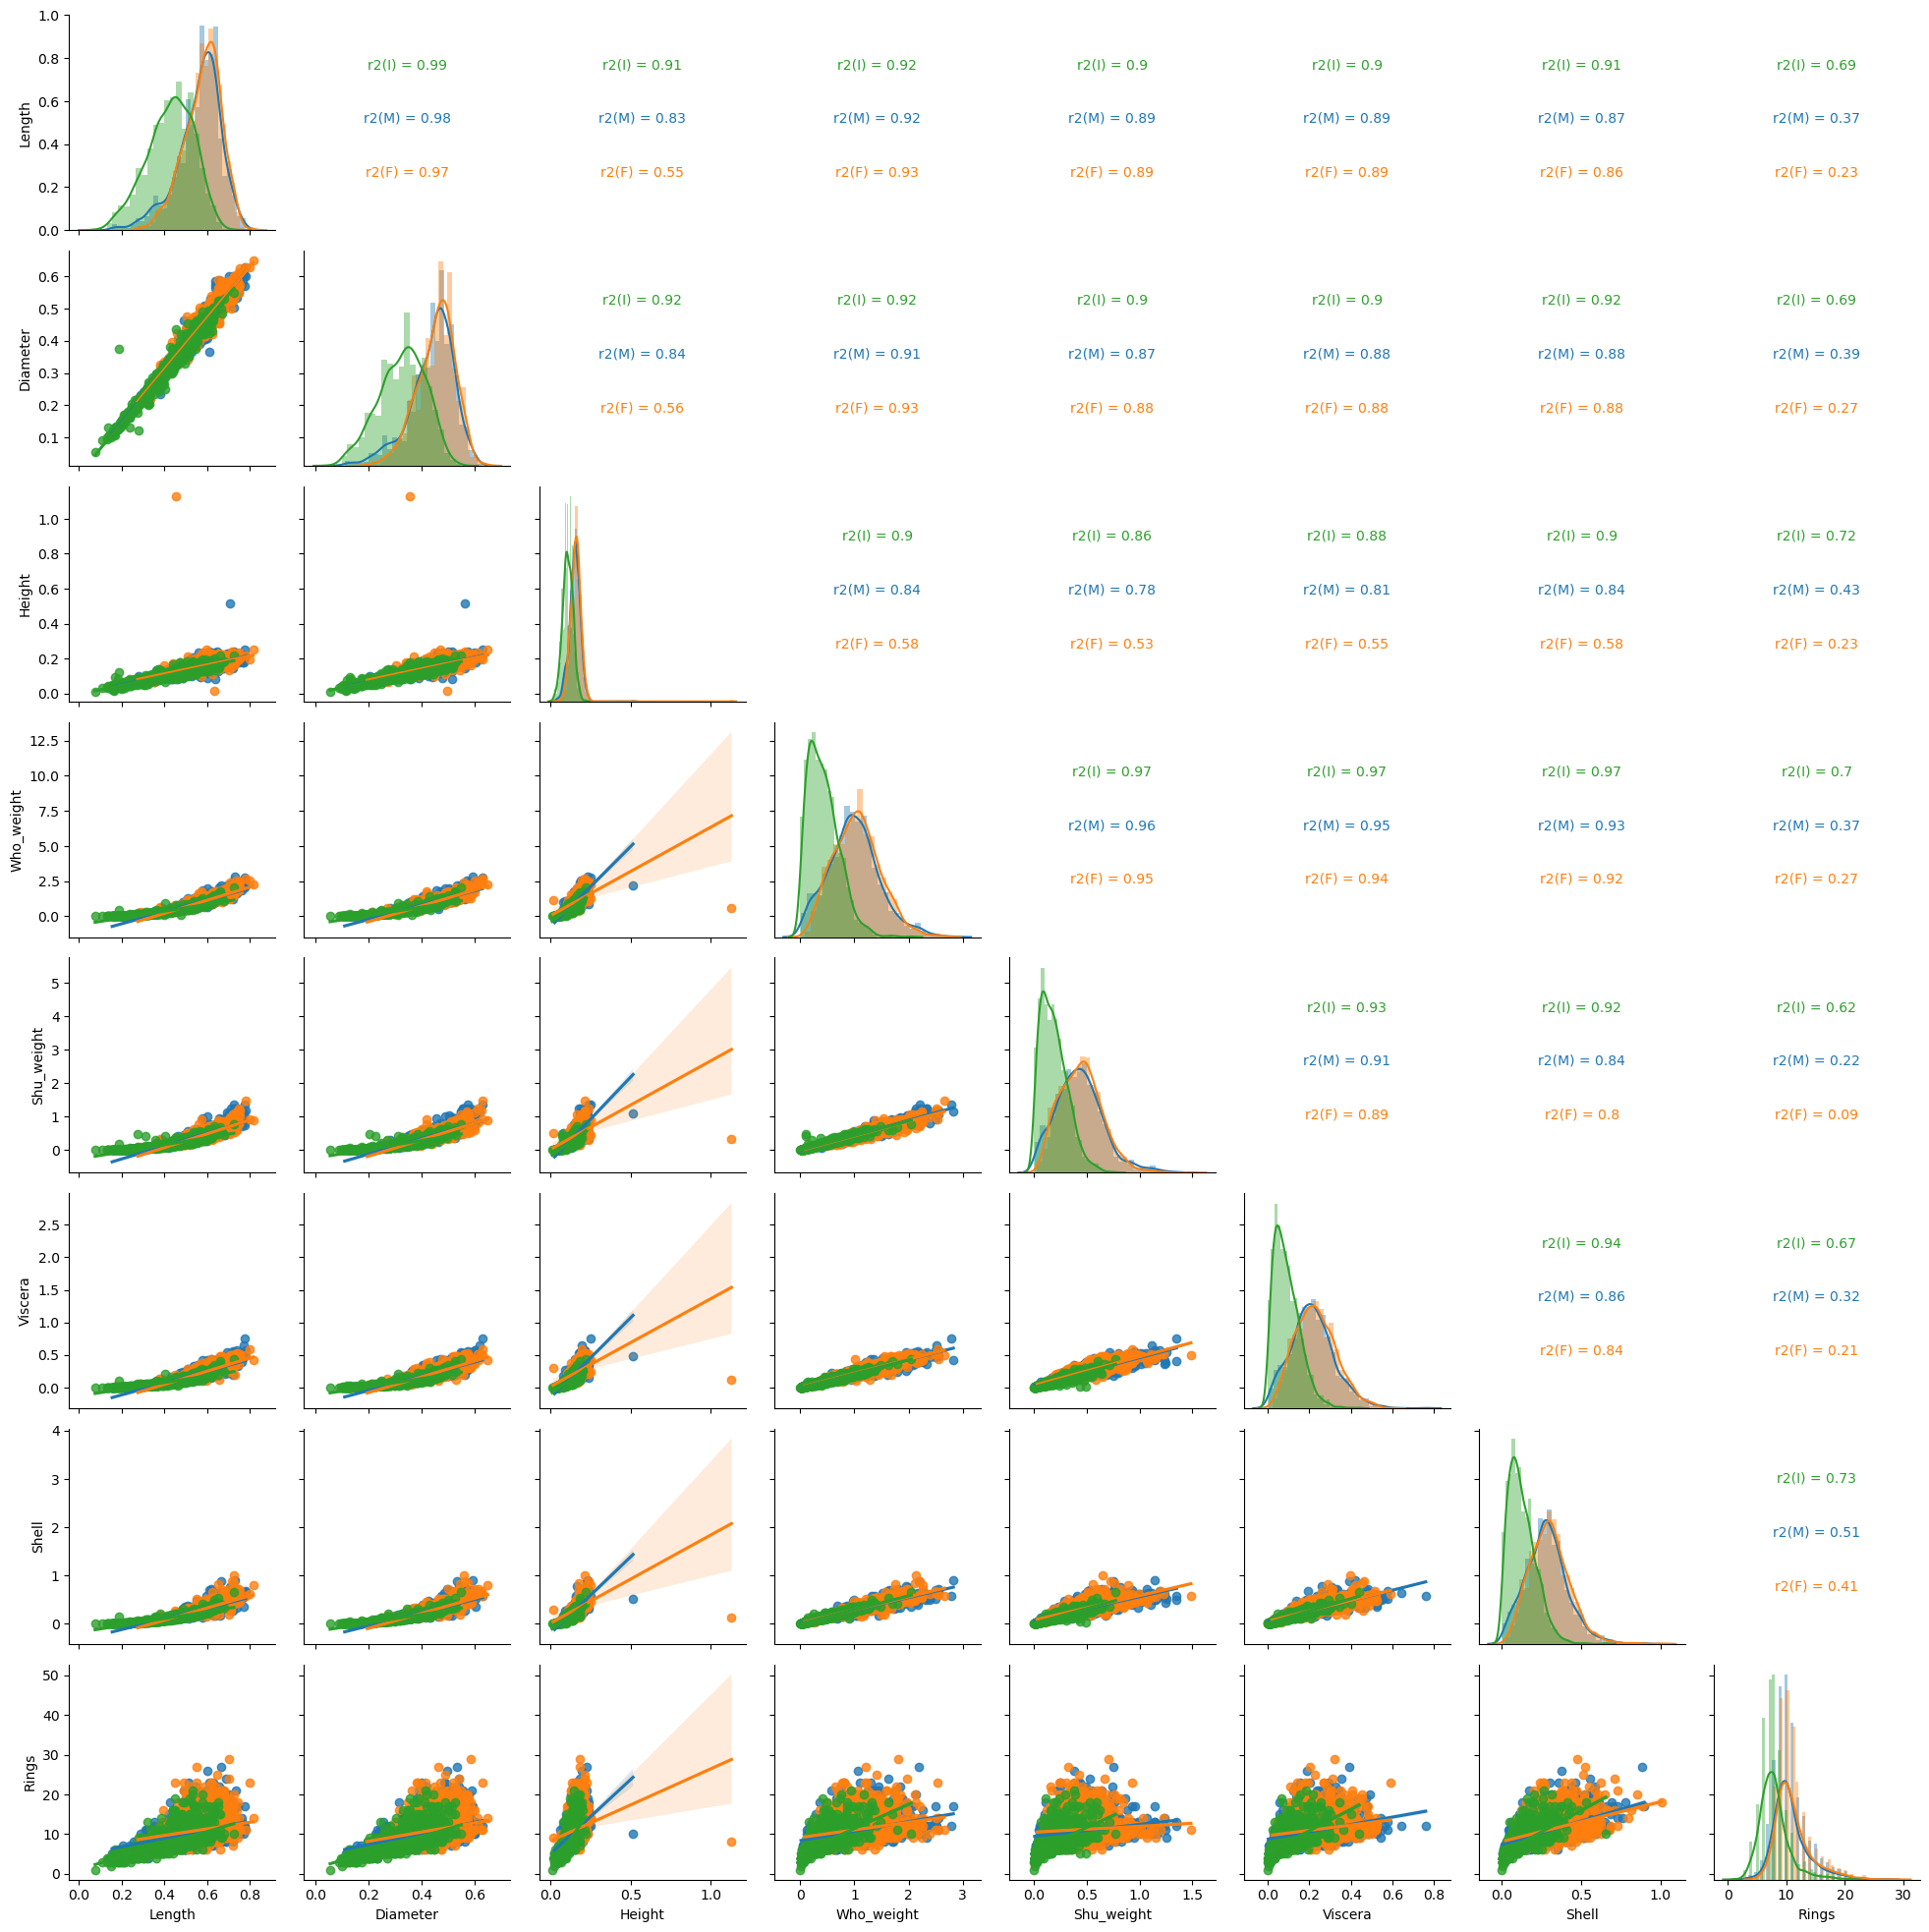

Analizando las distribuciones separadas por la variable `Sex`, nos podemos dar cuenta de que en todas las ocasiones la única distribución distinta es la de la de `Sex='I'`, y está más a la
izquierda por lo que tendrán menos cantidad (en cuanto a números se refiere) de todas las variables. Esto es lógico puesto que aún no se han desarrollado del todo.

Si nos vamos a los scatterplot, podremos observar las dependencias entre las variables. Si dos variables que no son la variable respuesta presentan una correlación alta, significará que nos están proporcionando la misma información, y esto no es lo que queremos. Un ejemplo de esto lo podemos ver en la pareja `Length-Diameter` que tiene un valor de correlación lineal de Pearson de 0.987 que es muy alto, pues se trata de un medida relativa, con su máximo en 1. Por otro lado, con la variable respuesta, `Rings`, queremos que pase lo contrario, es decir que tenga una correlación alta, para que de esta manera la variable predictora en cuestión explique lo mejor posible la respuesta. Lamentablemente, esto no ocurre en ninguno de los casos.

* Muestra un `boxplot` de cada una de las variables distinguiendo por `Sex`.

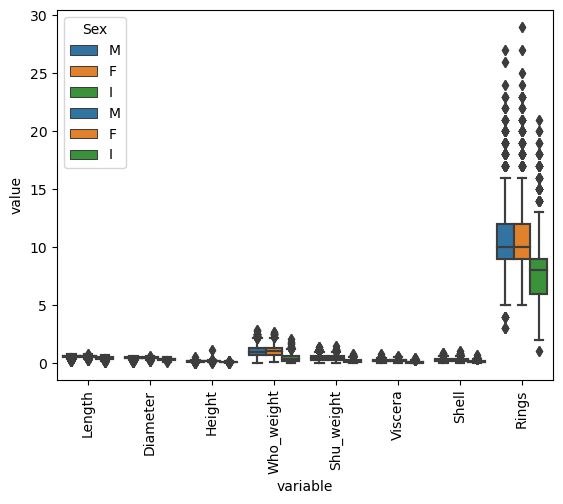

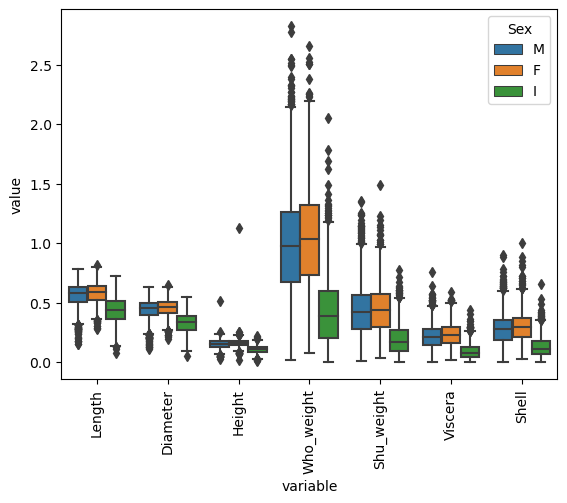

En los diagramas de caja y bigotes, también nos podremos dar cuenta de la similitud entre los géneros `F` y `M`. Además de eso también podemos ver los outliers, como por ejemplo ocurre
con la variable `Height`. Los dos puntos que aparecen a la derecha son muy probables outliers, sobretodo el de sex `F` cuyo valor supera con creces el resto de los valores. De hecho, si nos vamos al diagrama de dispersión de esta columna, vemos que la línea de regresión con respecto a los grupos que conforman las dos observaciones, están claramente influenciadas por estas
(la mayoría están en el clúster de la izquierda, pero esa observación está provocando que la tendencia general se desvíe mucho).

Como tenemos muchos datos, y lo más importante, nos van a distorsionar mucho el modelo, las vamos a quitar.

* Elimina las dos observaciones influyentes del conjunto de datos inicial.

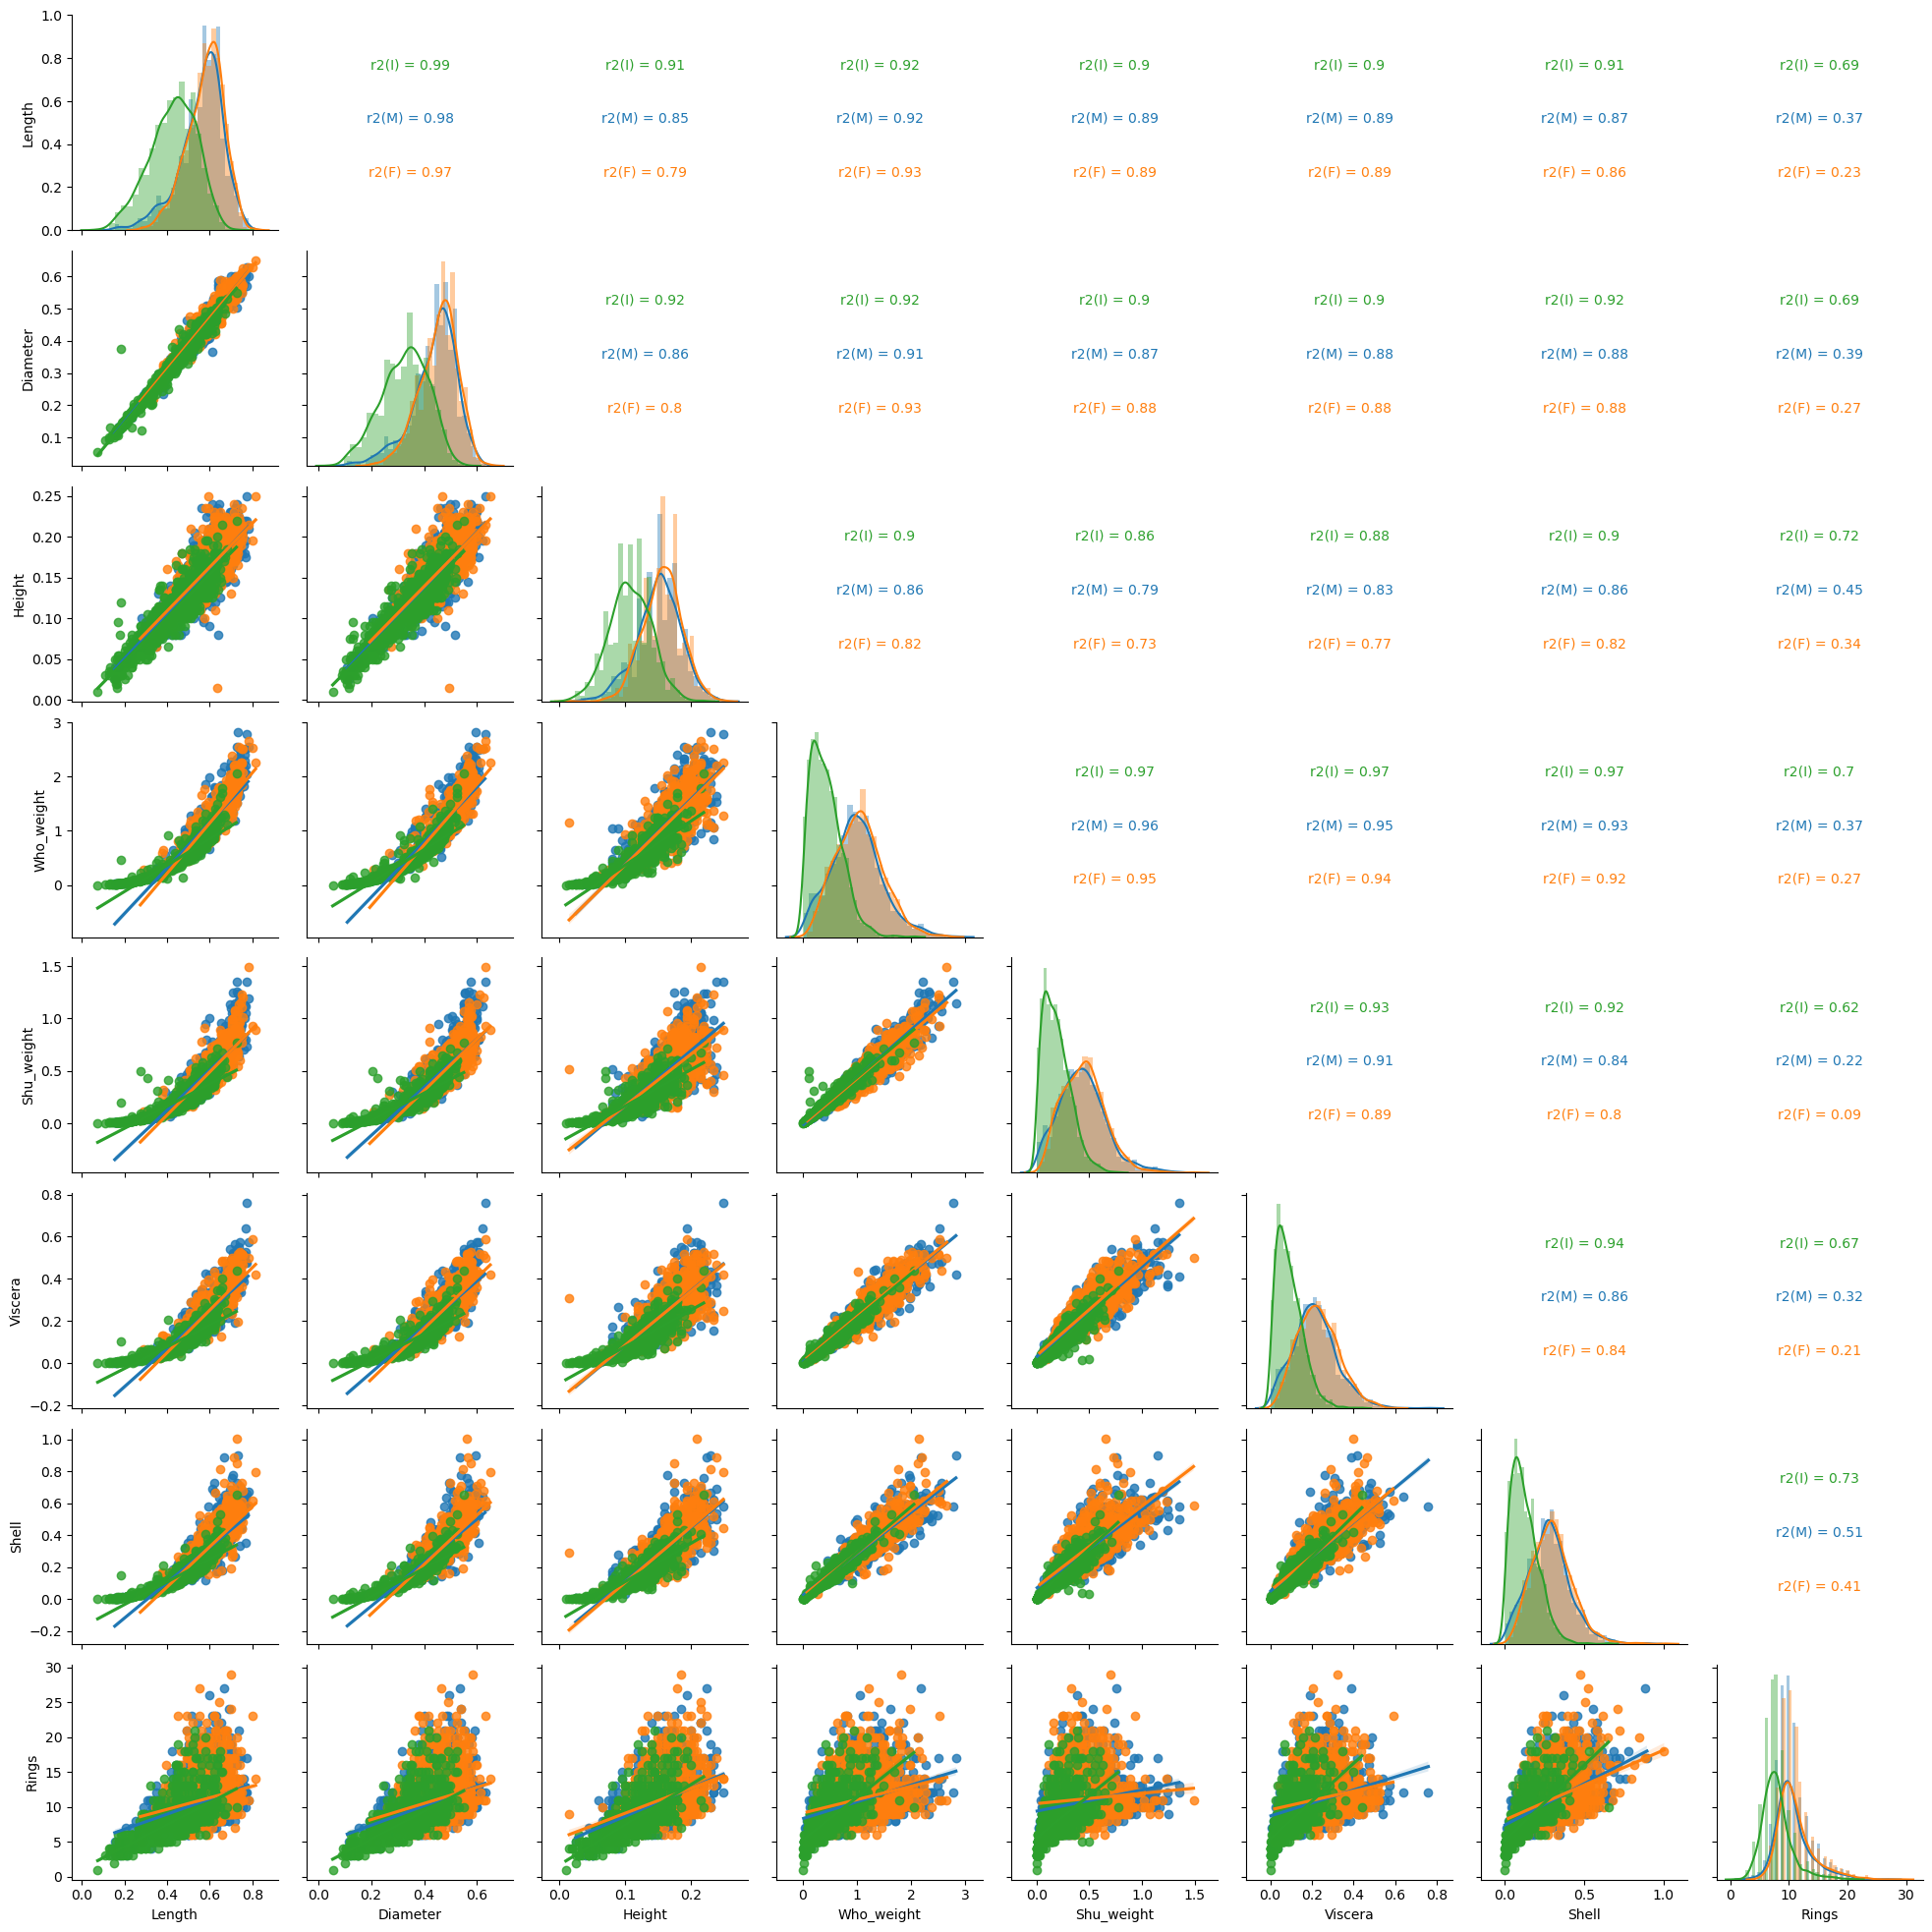

Observamos que la variable respuesta está discretizada. Además nos damos cuenta que la variable respuesta no sigue una distribución normal, sino que presenta largas colas a la derecha. Esto es un síntoma claro de que existe heterocedasticidad, por lo que recordemos que antes de aplicar cualquier modelo deberemos arreglarlo por ejemplo, introduciendo alguna de las transformaciones Boxcox estudiadas en la teoría.

## Partición de los conjuntos train - val - test

* Deja el 70% de las muestras para entrenar, el 20% de las muestras para el conjunto de validación y el 10% para el conjunto de test. Este último, no se tocará en la parte de modelización. Únicamente servirá para generar los estadísticos de predicción finales en la parte de "Generación de resultados finales". Recuerda que deberás mezclar los datos antes de hacer la selección por si tuviese algún orden implícito. Además, recuerda fijar la semilla para volver a generar las mismas divisiones la próxima vez que reejecutes todo el código.

## Modelización

¡Es hora de actuar! Con todos los modelos aprendidos hasta el momento, crea un modelo que te permita estimar la edad de los abalones en función de sus características físicas. Esta edad se calcula como el número de anillos más 1.5, así que el objetivo del estudio será calcular el número de anillos, variable `Rings`. Además, está discretizada por lo que puedes tratarla como una varaible numérica contínua o una variable discreta.

## Generación de resultados finales y conclusiones

Por último, mostramos el mejor modelo obtenido y predecimos con el conjunto de test que nos hemos dejado y proporcionamos los estadísticos de predicción, los cuales servirán para dar unas estimaciones de los errores que se cometerán con la llegada de nuevas muestras al laboratorio.